# Xarray-to-Zarr Sequential Recipe: NOAA OISST

This tutorial describes how to create a recipe from scratch.
The source data is a sequence of NetCDF files accessed via HTTP.
The target is a Zarr store.

## Step 1: Get to know your source data

If you are developing a new recipe, you are probably starting from an existing
dataset. The first step is to just get to know the dataset. For this tutorial,
our example will be the _NOAA Optimum Interpolation Sea Surface Temperature
(OISST) v2.1_. The authoritative website describing the data is
<https://www.ncdc.noaa.gov/oisst/optimum-interpolation-sea-surface-temperature-oisst-v21>.
This website contains links to the actual data files on the
[data access](https://www.ncdc.noaa.gov/oisst/data-access) page. We will use the
_AVHRR-Only_ version of the data and follow the corresponding link to the
[Gridded netCDF Data](https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/).
Browsing through the directories, we can see that there is one file per day. The
very first day of the dataset is stored at the following URL:

```text
https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc
```

From this example, we can work out the pattern of the file naming conventions.
But first, let's just download one of the files and open it up.


In [1]:
! wget https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc 

--2021-11-13 22:41:02--  https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc
Resolving www.ncei.noaa.gov... 205.167.25.177, 205.167.25.178, 205.167.25.167, ...
Connecting to www.ncei.noaa.gov|205.167.25.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1714749 (1.6M) [application/x-netcdf]
Saving to: ‘oisst-avhrr-v02r01.19810901.nc.1’

oisst-avhrr-v02r01. 100%[===================>]   1.63M  7.01MB/s    in 0.2s    

2021-11-13 22:41:03 (7.01 MB/s) - ‘oisst-avhrr-v02r01.19810901.nc.1’ saved [1714749/1714749]



In [2]:
import xarray as xr

ds = xr.open_dataset("oisst-avhrr-v02r01.19810901.nc")
ds

<xarray.Dataset>
Dimensions:  (time: 1, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 ...
    err      (time, zlev, lat, lon) float32 ...
    ice      (time, zlev, lat, lon) float32 ...
    sst      (time, zlev, lat, lon) float32 ...
Attributes: (12/37)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.19810901.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

We can see there are four data variables, all with dimension
`(time, zlev, lat, lon)`. There is a _dimension coordinate_ for each dimension,
and no _non-dimension coordinates_. Each file in the sequence presumably has the
same `zlev`, `lat`, and `lon`, but we expect `time` to be different in each one.

Let's also check the total size of the dataset in the file.


In [3]:
print(f"File size is {ds.nbytes/1e6} MB")

File size is 16.597452 MB


The file size is important because it will help us define the _chunk size_
Pangeo Forge will use to build up the target dataset.


## Step 2: Define File Pattern

The first step in developing a recipe is to define a {doc}`File Pattern </recipe_user_guide/file_patterns>`.
The file pattern describes how the source files (a.k.a. "inputs") are organized.

In this case, we have a very simple sequence of files that we want to concatenate along a single dimension (time), so we can use the helper function {func}`pangeo_forge_recipes.patterns.pattern_from_file_sequence`. This allows us to simply pass a list of URLs, which we define explicitly.

In [1]:
from pangeo_forge_recipes.patterns import pattern_from_file_sequence

pattern_from_file_sequence?

Signature:
pattern_from_file_sequence(
    file_list,
    concat_dim,
    nitems_per_file=None,
    **kwargs,
)
Docstring: Convenience function for creating a FilePattern from a list of files.
File:      ~/repos/copy/pangeo-forge-recipes/pangeo_forge_recipes/patterns.py
Type:      function


To populate the `file_list`, we need understand the file naming conventions. Let's look again at the first URL

```text
https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc
```

From this we deduce the following format string.

In [2]:
input_url_pattern = (
    "https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation"
    "/v2.1/access/avhrr/{yyyymm}/oisst-avhrr-v02r01.{yyyymmdd}.nc"
)

To convert this to an actual list of files, we use Pandas.
At the time of writing, the latest available data is from 2021-01-05.

In [3]:
import pandas as pd

dates = pd.date_range("1981-09-01", "2021-01-05", freq="D")
input_urls = [
    input_url_pattern.format(
        yyyymm=day.strftime("%Y%m"), yyyymmdd=day.strftime("%Y%m%d")
    )
    for day in dates
]
print(f"Found {len(input_urls)} files!")
input_urls[-1]

Found 14372 files!


'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/202101/oisst-avhrr-v02r01.20210105.nc'

Now we can define our pattern.
We will include one more piece of information: we know from examining the file above that there is only one timestep per file.
So we can set `nitems_per_file=1`.

In [4]:
pattern = pattern_from_file_sequence(input_urls, "time", nitems_per_file=1)
pattern

<FilePattern {'time': 14372}>

To check out pattern, we can try to get the data back out.
The pattern is designed to be iterated over, so to key the first key, we do:

In [5]:
for key in pattern:
    break
key

frozenset({DimIndex(name='time', index=0, sequence_len=14372, operation=<CombineOp.CONCAT: 2>)})

We can now use "getitem" syntax on the FilePattern object to retrieve the file name based on this key.

In [6]:
pattern[key]

'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'

As an alternative way to create the same pattern we could use the more verbose syntax to create a `FilePattern` class.
With this method, we have to define a function which returns the file path, given a particular key.
We might do it like this.

In [7]:
from pangeo_forge_recipes.patterns import ConcatDim, FilePattern

def format_function(time):
    return input_url_pattern.format(
        yyyymm=time.strftime("%Y%m"), yyyymmdd=time.strftime("%Y%m%d")
    )

concat_dim = ConcatDim(name="time", keys=dates, nitems_per_file=1)
pattern = FilePattern(format_function, concat_dim)
pattern

<FilePattern {'time': 14372}>

We can check that it gives us the same thing:

In [8]:
pattern[key]

'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'

## Step 3: Pick a Recipe class

Now that we have the file pattern defined, we have to plug it into a Recipe.
Since we are reading NetCDF files, we will use the {class}`pangeo_forge_recipes.recipe.XarrayZarrRecipe` class
Let's examine its documentation string in our notebook.

In [9]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe
XarrayZarrRecipe?

Init signature:
XarrayZarrRecipe(
    file_pattern: 'FilePattern',
    storage_config: 'StorageConfig' = <factory>,
    inputs_per_chunk: 'int' = 1,
    target_chunks: 'Dict[str, int]' = <factory>,
    cache_inputs: 'Optional[bool]' = None,
    copy_input_to_local_file: 'bool' = False,
    consolidate_zarr: 'bool' = True,
    consolidate_dimension_coordinates: 'bool' = True,
    xarray_open_kwargs: 'dict' = <factory>,
    xarray_concat_kwargs: 'dict' = <factory>,
    delete_input_encoding: 'bool' = True,
    process_input: 'Optional[Callable[[xr.Dataset, str], xr.Dataset]]' = None,
    process_chunk: 'Optional[Callable[[xr.Dataset], xr.Dataset]]' = None,
    lock_timeout: 'Optional[int]' = None,
    subset_inputs: 'SubsetSpec' = <factory>,
    open_input_with_fsspec_reference: 'bool' = False,
) -> None
Docstring:     
This configuration represents a dataset composed of many individual NetCDF files.
This class uses Xarray to read and write data and writes its output to Zarr.
The organiz

There are lots of optional parameters, but only `file_pattern` is required.
We can initialize our recipe by passing the file pattern to the recipe class.

In [10]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe

recipe = XarrayZarrRecipe(pattern)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 14372}>, storage_config=StorageConfig(target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x163d13850>, root_path='/var/folders/f8/rh42xb3d1tnbw2bxsjwgym1c0000gn/T/tmpvx_0odze/EdcokCSI'), cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x163d13850>, root_path='/var/folders/f8/rh42xb3d1tnbw2bxsjwgym1c0000gn/T/tmpvx_0odze/5hg1oqw0'), metadata=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x163d13850>, root_path='/var/folders/f8/rh42xb3d1tnbw2bxsjwgym1c0000gn/T/tmpvx_0odze/Z55lSU3y')), inputs_per_chunk=1, target_chunks={}, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={}, open_input_with_fsspec_reference=False)

Now let's think about the Zarr chunks that this recipe will produce.
Each target chunk corresponds to one input. So each variable chunk will only be a few MB.
That is too small. Let's increase `inputs_per_chunk` to 20.
This means that we will need to be able to hold 10 files like the one we examined above in memory at once.
That's `16MB * 10 = 160MB`. Not a problem!

In [11]:
recipe = XarrayZarrRecipe(pattern, inputs_per_chunk=10)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 14372}>, storage_config=StorageConfig(target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x163d13850>, root_path='/var/folders/f8/rh42xb3d1tnbw2bxsjwgym1c0000gn/T/tmpvx_0odze/wMMMcAJc'), cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x163d13850>, root_path='/var/folders/f8/rh42xb3d1tnbw2bxsjwgym1c0000gn/T/tmpvx_0odze/Owf4PRgA'), metadata=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x163d13850>, root_path='/var/folders/f8/rh42xb3d1tnbw2bxsjwgym1c0000gn/T/tmpvx_0odze/Pm4C7CHC')), inputs_per_chunk=10, target_chunks={}, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={}, open_input_with_fsspec_reference=False)

## Step 4: Play with the recipe

Now we will just explore our recipe a bit to check whether things make sense.

We will also turn on Pangeo Forge's logging.

In [13]:
from pangeo_forge_recipes.recipes import setup_logging

In [14]:
setup_logging()

We can see how many inputs the recipe has like this:

In [15]:
all_inputs = list(recipe.iter_inputs())
len(all_inputs)

14372

And how many chunks:

In [16]:
all_chunks = list(recipe.iter_chunks())
len(all_chunks)

1438

We can now try to load the first chunk. This will raise an exception because we have not initialized any targets.

(Note that the ``open_chunk`` and ``open_input`` methods must be called as context managers. 

In [22]:
%xmode minimal
with recipe.open_chunk(all_chunks[0]) as ds:
    display(ds)

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc' directly.


Exception reporting mode: Minimal


pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-1: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810902.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810902.nc' directly.
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-2: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810903.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810903.nc' directly.
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-3: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/ois

<xarray.Dataset>
Dimensions:  (time: 10, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 1981-09-10T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.19810901.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

## Step 5: Create storage targets

In order to run our recipe, we need to define two places to store data:
- The Input Cache, where we will temporarily store the files we have downloaded
- The Target, where the final Zarr dataset will live


In [23]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge_recipes.storage import FSSpecTarget, CacheFSSpecTarget

fs_local = LocalFileSystem()

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

recipe.input_cache = cache_target
recipe.target = target
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 14372}>, inputs_per_chunk=10, target_chunks={}, target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x178648250>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmpposj81z1'), input_cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x178648250>, root_path='/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmpvnqwkl4t'), metadata_cache=None, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={}, open_input_with_fsspec_reference=False)

Now we try to load the chunk.

In [24]:
try:
    with recipe.open_chunk(all_chunks[0]) as ds:
        display(ds)
except FileNotFoundError as e:
    print(e)

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc' from cache


[Errno 2] No such file or directory: '/var/folders/n8/63q49ms55wxcj_gfbtykwp5r0000gn/T/tmpvnqwkl4t/fe866b608e5c7eafba93f06954124ba1-https_www.ncei.noaa.gov_data_sea-surface-temperature-optimum-interpolation_v2.1_access_avhrr_198109_oisst-avhrr-v02r01.19810901.nc'


It still didn't work! That's because we have not cached the inputs yet. We can have the recipe tell us which inputs are needed for each chunk via the `inputs_for_chunk` method.

In [25]:
for input_file in recipe.inputs_for_chunk(all_chunks[0]):
    recipe.cache_input(input_file)

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching input 'time-0'
pangeo_forge_recipes.storage:INFO - Caching file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'
pangeo_forge_recipes.storage:INFO - Copying remote file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc' to cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching input 'time-1'
pangeo_forge_recipes.storage:INFO - Caching file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810902.nc'
pangeo_forge_recipes.storage:INFO - Copying remote file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810902.nc' to cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching input 'time-2'
pangeo_forge_recipe

## Step 6: Examine some chunks

Now we can finally open the first chunk!

In [26]:
with recipe.open_chunk(all_chunks[0]) as ds:
    display(ds)
    # need to load if we want to access the data outside of the context
    ds.load()

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-1: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810902.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810902.nc' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-2: 'https://www.ncei.noaa.g

<xarray.Dataset>
Dimensions:  (time: 10, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 1981-09-10T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.19810901.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

In [27]:
print(f'Total chunk size: {ds.nbytes / 1e6} MB')

Total chunk size: 165.896724 MB


👀 Inspect the Xarray HTML repr above carefully by clicking on the buttons to expand the different sections.
- ✅ Is the shape of the variable what we expect?
- ✅ Is `time` going in the right order?
- ✅ Do the variable attributes make sense?


Now let's visualize some data and make sure things look good

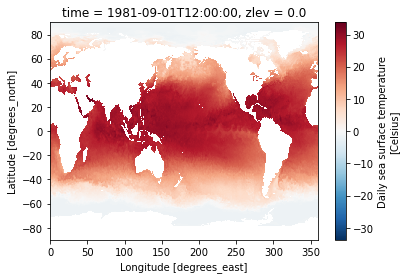

In [28]:
ds.sst[0].plot()

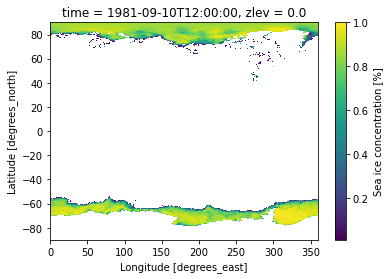

In [29]:
ds.ice[-1].plot()

The data look good!
Now let's try a random chunk from the middle.

In [30]:
chunk_number = 500
chunk_key = list(recipe.iter_chunks())[chunk_number]
for input_file in recipe.inputs_for_chunk(chunk_key):
    recipe.cache_input(input_file)

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching input 'time-5000'
pangeo_forge_recipes.storage:INFO - Caching file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/199505/oisst-avhrr-v02r01.19950511.nc'
pangeo_forge_recipes.storage:INFO - Copying remote file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/199505/oisst-avhrr-v02r01.19950511.nc' to cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching input 'time-5001'
pangeo_forge_recipes.storage:INFO - Caching file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/199505/oisst-avhrr-v02r01.19950512.nc'
pangeo_forge_recipes.storage:INFO - Copying remote file 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/199505/oisst-avhrr-v02r01.19950512.nc' to cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching input 'time-5002'
pangeo_for

In [31]:
with recipe.open_chunk(chunk_key) as ds_chunk:
    ds_chunk.load()
ds_chunk

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-500
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-5000: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/199505/oisst-avhrr-v02r01.19950511.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/199505/oisst-avhrr-v02r01.19950511.nc' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-5001: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/199505/oisst-avhrr-v02r01.19950512.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/199505/oisst-avhrr-v02r01.19950512.nc' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-5002: 'https://www.

<xarray.Dataset>
Dimensions:  (time: 10, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1995-05-11T12:00:00 ... 1995-05-20T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 nan nan nan nan ... 0.11 0.11 0.11
    err      (time, zlev, lat, lon) float32 nan nan nan nan ... 0.3 0.3 0.3 0.3
    ice      (time, zlev, lat, lon) float32 nan nan nan nan ... 0.97 0.97 0.97
    sst      (time, zlev, lat, lon) float32 nan nan nan ... -1.69 -1.69 -1.69
Attributes: (12/37)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.19950511.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

## Step 7: Try writing data

Now that we can see our chunks opening correctly, we are ready to try writing data to our target.

First we need to prepare the target.

In [32]:
recipe.prepare_target()

/Users/rpa/pangeo-forge/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py:116: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(target.get_mapper())
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Creating a new dataset in target
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr

We should now see a Zarr group at the target location.
Only the coordinates have been written, not the data variables.

In [33]:
import zarr
zgroup = zarr.open(target_dir.name)
print(zgroup.tree())

/
 ├── anom (14372, 1, 720, 1440) float32
 ├── err (14372, 1, 720, 1440) float32
 ├── ice (14372, 1, 720, 1440) float32
 ├── lat (720,) float32
 ├── lon (1440,) float32
 ├── sst (14372, 1, 720, 1440) float32
 ├── time (14372,) int64
 └── zlev (1,) float32


Let's examine one of the data variables.

In [34]:
zgroup['sst'].info

Name,/sst
Type,zarr.core.Array
Data type,float32
Shape,"(14372, 1, 720, 1440)"
Chunk shape,"(10, 1, 720, 1440)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,59603558400 (55.5G)
No. bytes stored,611


Now let's write the first chunk.

In [35]:
recipe.store_chunk(all_chunks[0])
zgroup['sst'].info

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810901.nc' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-1: 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810902.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr/198109/oisst-avhrr-v02r01.19810902.nc' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-2: 'https://www.ncei.noaa.g

Name,/sst
Type,zarr.core.Array
Data type,float32
Shape,"(14372, 1, 720, 1440)"
Chunk shape,"(10, 1, 720, 1440)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,59603558400 (55.5G)
No. bytes stored,19921052 (19.0M)


We can see that one of the chunks has been written! 🎉

We can also open the dataset with xarray

In [36]:
ds = xr.open_zarr(target_dir.name)
ds

<xarray.Dataset>
Dimensions:  (time: 10, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 1981-09-10T12:00:00
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 dask.array<chunksize=(10, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 dask.array<chunksize=(10, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 dask.array<chunksize=(10, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 dask.array<chunksize=(10, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    Conventions:                CF-1.6, ACDD-1.3
    cdm_data_type:              Grid
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    creator_email:              oisst-help@noaa.gov
    creator_url:                https://www.ncei.noaa.gov/
    date_created:               2020-05-08T19:05:13Z
    ...                         ...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    time_coverage_end:          1981-09-01T23:59:59Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...

There should be data at the beginning...

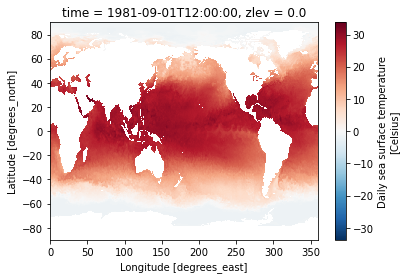

In [37]:
ds.sst[0].plot()

But not the end...

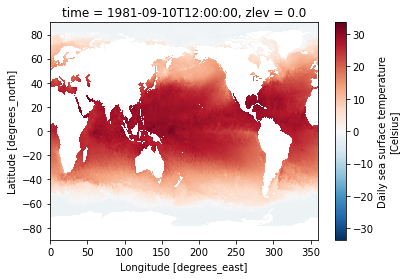

In [38]:
ds.sst[-1].plot()

## Postscript: Execute the full recipe

We are now confident that our recipe works as we expect.
At this point we could either:
- Execute it all ourselves (see {doc}`/recipe_user_guide/execution`)
- Create a new recipe feedstock on Pangeo Forge

If we wanted to execute it ourselves, one way would be to simply run the following code
```python
for input_name in recipe.iter_inputs():
    recipe.cache_input(input_name)
recipe.prepare_target()
for chunk in recipe.iter_chunks():
    recipe.store_chunk(chunk)
recipe.finalize_target()
```

We aren't going to do this in this notebook because it would take too long.

But hopefully now you have a better understanding of how Pangeo Forge recipes work.